# **5. Modelo Original**

SQRE-Predictor es un enfoque de modelado en conjunto (ensemble learning) para predecir la variable RETIROS_REDENCIONES a partir de características financieras como APORTES_RECIBIDOS, PRECIERRE_FONDO_DIA_T, entre otras. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

## **5.1. Implementación**

Para la implementación, primero se cargan los datos desde un archivo CSV y se dividen en conjuntos de entrenamiento y prueba. Luego, se entrenan tres modelos base: XGBoost, Random Forest y K-Nearest Neighbors (KNN), cada uno con hiperparámetros cuidadosamente seleccionados para mejorar la generalización y evitar el sobreajuste. Las predicciones de estos modelos sobre los datos de entrenamiento y prueba se apilan (stacking) como entradas para un meta-modelo final: un Gradient Boosting Regressor con pérdida tipo cuantil (quantile), usado para robustecer las predicciones. Finalmente, se calculan métricas de rendimiento como RMSE, MAE y R² para evaluar la precisión del modelo combinado tanto en entrenamiento como en prueba. Este pipeline busca aprovechar las fortalezas individuales de cada modelo base y mejorar el desempeño global mediante una estrategia de aprendizaje en capas.

In [ ]:

# -------------------------------
# Cargar datos
# -------------------------------
df = pd.read_csv(r'C:\Users\TAWTOCA\OneDrive - Universidad del Norte\Documentos\Visual Folders\Visual Files\Rentabilidad_filtrado.csv')

X = df[["APORTES_RECIBIDOS", "PRECIERRE_FONDO_DIA_T", "TIPO_PARTICIPACION", "NUMERO_INVERSIONISTAS", "TIPO_ENTIDAD"]]
y = df["RETIROS_REDENCIONES"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# -------------------------------
# Entrenar modelos base optimizados
# -------------------------------
print("Entrenando modelo XGBoost...")
eval_set = [(X_train, y_train), (X_test, y_test)]

model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.03, max_depth=7, early_stopping_rounds=20,
    min_child_weight=1,     # Controlar la división de nodos para evitar sobreajuste
    gamma=1,
    subsample=0.88,          # Tomar muestras de los datos para evitar sobreajuste
    colsample_bytree=0.8,
    reg_lambda=1,           # Regularización L2 (evita sobreajuste)
    tree_method='hist',     # Algoritmo optimizado para conjuntos grandes
    eval_metric="rmse",  random_state=42, n_jobs=-1)

model_xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)


print("Entrenando modelo Random Forest...")
model_rf = RandomForestRegressor(n_estimators=500, max_depth=30, min_samples_leaf= 1,
                                 min_samples_split=10, max_features='log2', bootstrap= True, random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)

print("Entrenando modelo KNN...")
model_knn = KNeighborsRegressor(n_neighbors=15, weights='uniform', p=2,algorithm='ball_tree', leaf_size=30, n_jobs=-1)
model_knn.fit(X_train, y_train)

# -------------------------------
# Crear predicciones para meta-modelo
# -------------------------------
pred_train_xgb = model_xgb.predict(X_train)
pred_train_rf = model_rf.predict(X_train)
pred_train_knn = model_knn.predict(X_train)

X_meta_train = np.column_stack((pred_train_xgb, pred_train_rf, pred_train_knn))

pred_test_xgb = model_xgb.predict(X_test)
pred_test_rf = model_rf.predict(X_test)
pred_test_knn = model_knn.predict(X_test)

X_meta_test = np.column_stack((pred_test_xgb, pred_test_rf, pred_test_knn))

# -------------------------------
# Meta-modelo robusto 
# -------------------------------
print("Entrenando meta-modelo GradientBoosting (quantile)...")
meta_model = GradientBoostingRegressor(loss='quantile', alpha=0.5, n_estimators=500,
                                       learning_rate=0.05, max_depth=3, subsample=0.8, random_state=42)
st = time.time()
meta_model.fit(X_meta_train, y_train)
et = time.time()
print(f"Tiempo de entrenamiento del meta-modelo: {et - st:.2f} segundos")
# -------------------------------
# Predicciones finales
# -------------------------------
y_train_pred = meta_model.predict(X_meta_train)
y_test_pred = meta_model.predict(X_meta_test)

# -------------------------------
# Métricas
# -------------------------------
def print_metrics(y_true, y_pred, label=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"🔹 {label}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  R²:   {r2:.2f}\n")

print_metrics(y_train, y_train_pred, label="Entrenamiento")
print_metrics(y_test, y_test_pred, label="Prueba")



Entrenando modelo XGBoost...
Entrenando modelo Random Forest...
Entrenando modelo KNN...
Entrenando meta-modelo GradientBoosting (quantile)...
Tiempo de entrenamiento del meta-modelo: 374.49 segundos
🔹 Entrenamiento
  RMSE: 19623504342.83
  MAE:  3158310557.69
  R²:   0.81

🔹 Prueba
  RMSE: 20241507018.19
  MAE:  5265511403.22
  R²:   0.78



Los resultados obtenidos muestran un buen desempeño general del modelo en ambas fases. En el conjunto de entrenamiento, se observa un R² de 0.81, lo que indica que el modelo explica el 81% de la variabilidad en los datos. Las métricas de error —RMSE de aproximadamente 19.6 mil millones y MAE de 3.15 mil millones— reflejan cierta magnitud en los errores absolutos, lo cual puede ser aceptable dependiendo de la escala de la variable objetivo (RETIROS_REDENCIONES), que parece tener valores grandes.

En el conjunto de prueba, el R² baja ligeramente a 0.78, y los errores aumentan, especialmente el MAE, que sube a más de 5.2 mil millones. Este incremento sugiere que el modelo pierde algo de precisión en generalización, pero sin señales claras de sobreajuste, ya que la caída en el rendimiento no es drástica.

In [2]:
# -------------------------------
# Métricas individuales
# -------------------------------
def print_metrics(y_true, y_pred, label=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"🔹 {label}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  R²:   {r2:.2f}\n")

print("\n=== XGBoost ===")
print_metrics(y_train, pred_train_xgb, label="Entrenamiento")
print_metrics(y_test, pred_test_xgb, label="Prueba")

print("\n=== Random Forest ===")
print_metrics(y_train, pred_train_rf, label="Entrenamiento")
print_metrics(y_test, pred_test_rf, label="Prueba")

print("\n=== KNN ===")
print_metrics(y_train, pred_train_knn, label="Entrenamiento")
print_metrics(y_test, pred_test_knn, label="Prueba")



=== XGBoost ===
🔹 Entrenamiento
  RMSE: 21049058930.67
  MAE:  6305639398.00
  R²:   0.79

🔹 Prueba
  RMSE: 22084179014.20
  MAE:  6443997051.38
  R²:   0.74


=== Random Forest ===
🔹 Entrenamiento
  RMSE: 14107003383.17
  MAE:  3515494264.48
  R²:   0.90

🔹 Prueba
  RMSE: 20051914981.17
  MAE:  5312030138.88
  R²:   0.79


=== KNN ===
🔹 Entrenamiento
  RMSE: 25629720094.02
  MAE:  6445112502.67
  R²:   0.68

🔹 Prueba
  RMSE: 23199936988.02
  MAE:  6935039370.78
  R²:   0.71



## **5.2. Resultados Visuales**

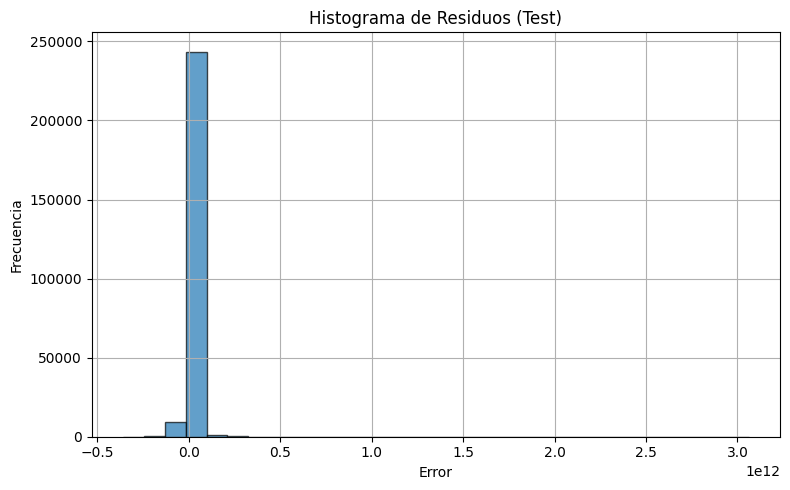

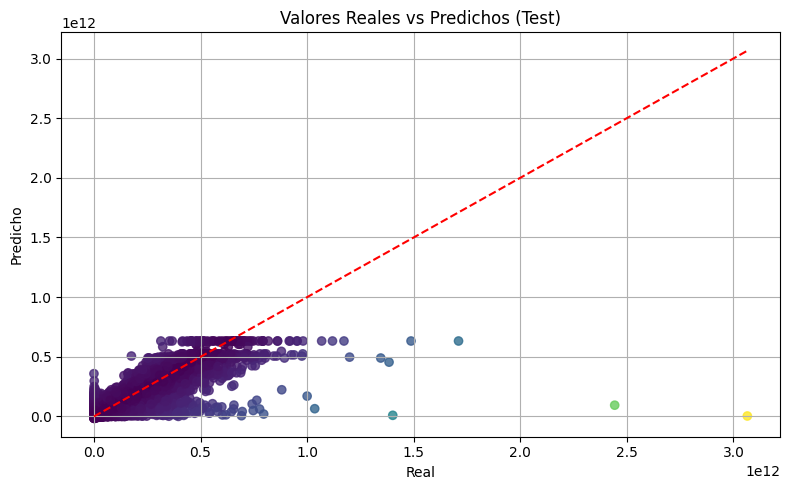

<Figure size 1000x400 with 0 Axes>

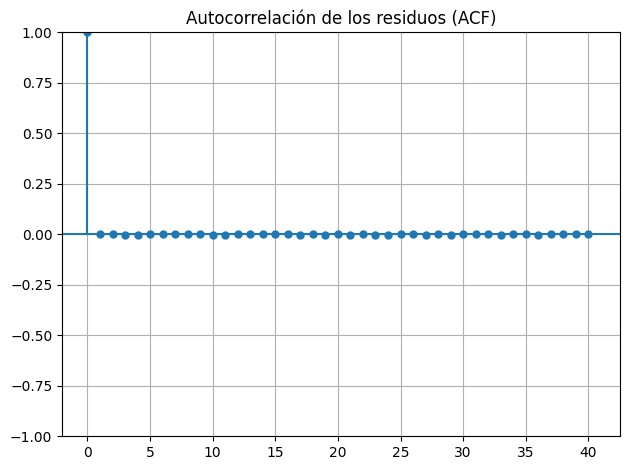

In [7]:
# -------------------------------
# Histograma de residuos
# -------------------------------
residuals = y_test - y_test_pred
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histograma de Residuos (Test)')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# Gráfico real vs predicho
# -------------------------------
plt.figure(figsize=(8, 5))
scatter = plt.scatter(y_test, y_test_pred, c=np.abs(residuals), cmap='viridis', alpha=0.8)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Valores Reales vs Predichos (Test)')
plt.xlabel('Real')
plt.ylabel('Predicho')
plt.grid(True)
plt.tight_layout()
plt.show()


# -------------------------------
# Gráfico ACF de los residuos
# -------------------------------
plt.figure(figsize=(10, 4))
plot_acf(residuals, lags=40, alpha=0.05)
plt.title("Autocorrelación de los residuos (ACF)")
plt.grid(True)
plt.tight_layout()
plt.show()


🔹 **Histograma de residuos**
La mayoría de los residuos están fuertemente concentrados cerca de cero, lo cual es una buena señal de que el modelo no comete errores sistemáticos en la mayoría de los casos. Sin embargo, se observan algunos residuos extremos (outliers) hacia la derecha del gráfico, lo que indica que en ciertas observaciones el modelo incurre en errores muy grandes. Esto sugiere una posible presencia de valores atípicos en la variable objetivo que podrían estar afectando el desempeño.

---

🔹 **Gráfico de valores reales vs predichos**
La mayoría de los puntos se agrupan en la parte inferior izquierda del gráfico, lo que indica que la mayor parte de las observaciones tienen valores reales y predichos bajos. Aunque hay una tendencia general que sigue la línea ideal (roja discontinua), se observan varios puntos alejados de esta, especialmente en valores altos de la variable real, donde el modelo tiende a **subestimar o sobreestimar considerablemente**. Esto refleja que el modelo tiene **dificultad para predecir correctamente valores extremos o muy altos**, lo que coincide con los outliers observados en el histograma.

---

🔹 **Gráfico ACF de los residuos**
El gráfico muestra que no existe autocorrelación significativa en los residuos para los primeros 40 lags, ya que todos los valores (excepto el lag 0, que es siempre 1) están dentro del intervalo de confianza. Esto es un buen indicador, ya que implica que los errores del modelo están distribuidos aleatoriamente y no contienen patrones temporales o secuenciales no capturados por el modelo.



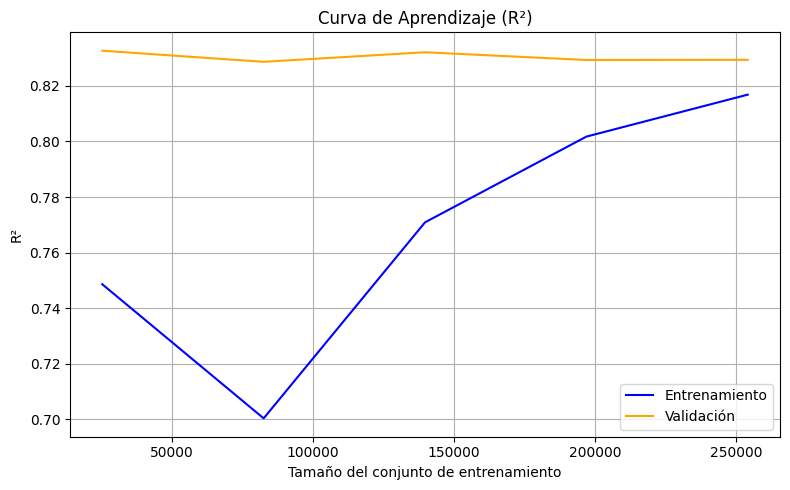

In [4]:
from sklearn.model_selection import learning_curve

# Rápido: menos puntos, menos folds
train_sizes, train_scores, test_scores = learning_curve(
    meta_model, X_meta_train, y_train,
    cv=3,                   # menos folds
    scoring='r2',           # usamos R²
    train_sizes=np.linspace(0.1, 1.0, 5),  # solo 5 puntos
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Promediar los scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label='Entrenamiento', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Validación', color='orange')
plt.title('Curva de Aprendizaje (R²)')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('R²')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


La gráfica muestra cómo evoluciona el desempeño del modelo en función del tamaño del conjunto de entrenamiento. Se observa una brecha significativa entre las curvas de entrenamiento y validación al inicio, lo cual es típico de modelos que aún no han aprendido lo suficiente. A medida que aumenta el tamaño del conjunto de entrenamiento, el rendimiento en entrenamiento mejora progresivamente y se acerca al desempeño en validación, lo que sugiere que el modelo se beneficia de más datos y está generalizando cada vez mejor. El hecho de que la curva de validación se mantenga estable indica que no hay sobreajuste evidente. 

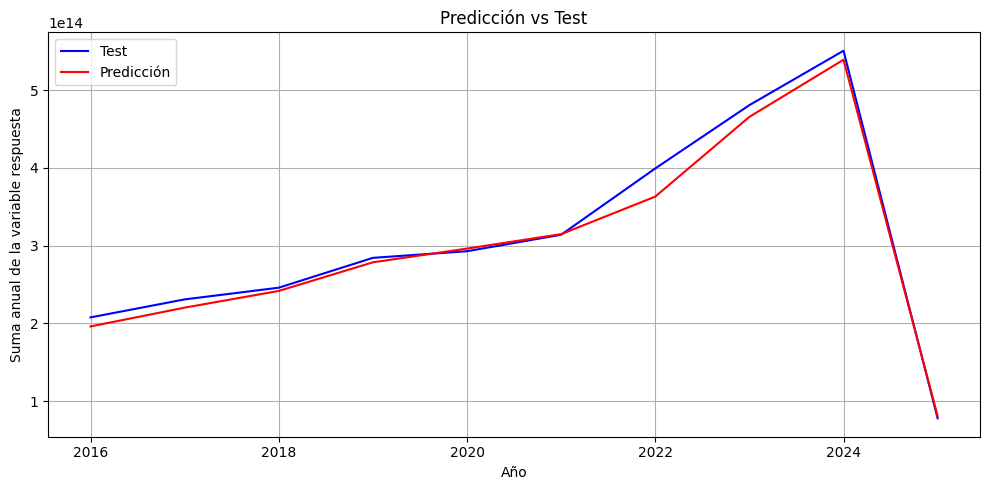

In [5]:
def predecir_y_graficar_por_anio(meta_model, X_meta_test, y_test, df_original, columna_fecha="FECHA_CORTE", titulo="Predicción vs Test"):
    """
    Genera predicciones del meta-modelo y grafica la evolución anual (suma por año) de las predicciones vs valores reales.

    Parámetros:
    - meta_model: modelo final entrenado.
    - X_meta_test: matriz con las predicciones de los modelos base.
    - y_test: Serie con los valores reales (ya separado).
    - df_original: DataFrame original completo que contiene la columna de fecha.
    - columna_fecha: nombre de la columna con la fecha en df_original.
    - titulo: título del gráfico.
    """
    # Obtener los índices originales de X_test (para alinear fechas)
    indices_test = X_test.index

    # Extraer fechas desde el DataFrame original
    fechas_test = pd.to_datetime(df_original.loc[indices_test, columna_fecha], dayfirst=True, errors='coerce')

    # Extraer año
    anios = fechas_test.dt.year

    # Predecir con meta-modelo
    y_pred = meta_model.predict(X_meta_test)

    # Crear DataFrame de resultados
    df_resultados = pd.DataFrame({
        'anio': anios.values,
        'real': y_test.values,
        'prediccion': y_pred
    })

    # Agrupar por año y sumar
    suma_anual = df_resultados.groupby('anio').sum().sort_index()

    # Graficar
    plt.figure(figsize=(10, 5))
    plt.plot(suma_anual.index, suma_anual['real'], 'blue', label='Test')
    plt.plot(suma_anual.index, suma_anual['prediccion'], 'red', label='Predicción')
    plt.title(titulo)
    plt.xlabel("Año")
    plt.ylabel("Suma anual de la variable respuesta")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return suma_anual


suma_anual = predecir_y_graficar_por_anio(meta_model, X_meta_test, y_test, df)


La gráfica compara la suma anual de los valores reales y predichos de la variable objetivo. Se aprecia que el modelo sigue bastante bien la tendencia general del comportamiento anual, especialmente en los años recientes, lo cual indica una buena capacidad de capturar patrones globales.

In [10]:
# Usamos el conjunto de test para evaluar la importancia
result = permutation_importance(
    meta_model, X_meta_test, y_test,
    n_repeats=10,        # repeticiones para robustez
    scoring='neg_mean_squared_error', 
    random_state=42, 
    n_jobs=-1
)


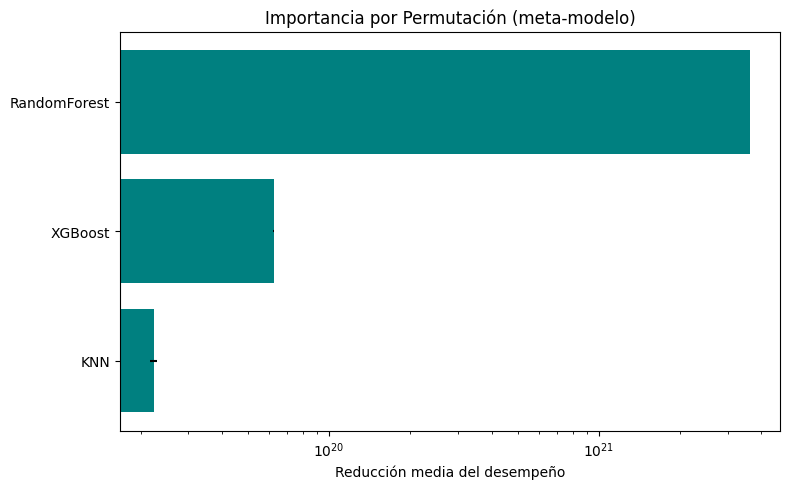

In [17]:
# Etiquetas de las variables base
feature_names = ['XGBoost', 'RandomForest', 'KNN']

# Ordenar por importancia media
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(8, 5))
plt.barh(
    range(len(sorted_idx)),
    result.importances_mean[sorted_idx],
    xerr=result.importances_std[sorted_idx],
    align='center',
    color='teal'  # Cambia el color aquí
)
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.title("Importancia por Permutación (meta-modelo)")
plt.xlabel("Reducción media del desempeño")
plt.xscale('log')  # Si estás usando escala logarítmica
plt.tight_layout()
plt.show()


Esta gráfica muestra la contribución relativa de cada modelo base al desempeño del meta-modelo, medida por la reducción en el rendimiento al permutar sus predicciones. Se observa claramente que Random Forest es el componente más influyente, lo que indica que sus predicciones son las más útiles para el meta-modelo. XGBoost también aporta de forma significativa, aunque en menor medida, mientras que KNN tiene una importancia marginal, posiblemente porque su rendimiento individual es más débil o menos complementario.